In [11]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr

In [4]:
filename = '/scratch/jw8736/multilayer-test/breaking/field/ux_matrix_t0_l22'
f = np.fromfile(filename, dtype=np.float32)
f = f.reshape(257, 257); f = f[1:,1:]

In [21]:
''' Basic reading files '''
def array_to_mesh (h_ensem, L0=200, H=40, Nh=512, Nl=15):
 
    x_mesh = np.zeros([Nl+1,Nh+1,Nh+1]) # Different from the vtk format
    y_mesh = np.zeros([Nl+1,Nh+1,Nh+1])
    z_mesh = np.zeros([Nl+1,Nh+1,Nh+1])

    h_ensem_expand = np.zeros([Nl,Nh+1,Nh+1]) # Need to go from centered to grid, pad the array
    h_ensem_expand[:,:Nh,:Nh] = np.copy(h_ensem) # Need to go from centered to grid
    h_ensem_expand[:,Nh,:Nh] = np.copy(h_ensem[:,Nh-1,:Nh])
    h_ensem_expand[:,:Nh,Nh] = np.copy(h_ensem[:,:Nh,Nh-1])
    h_ensem_expand[:,Nh,Nh] = np.copy(h_ensem[:,Nh-1,Nh-1])
    h_ensem_expand = np.array(h_ensem_expand)

    xarray = np.linspace(-L0/2, L0/2, Nh+1, endpoint=True)
    yarray = np.linspace(-L0/2, L0/2, Nh+1, endpoint=True)
    
    for k in range(Nl+1):
        for i in range(Nh+1):
            for j in range(Nh+1):
                z_mesh[k,i,j] = np.sum(h_ensem_expand[:k,i,j]) - H
                x_mesh[k,i,j] = xarray[i]
                y_mesh[k,i,j] = yarray[j]

    return x_mesh, y_mesh, z_mesh
    
def read (filepath='/projects/DEIKE/jiarongw/multilayer/stokes/stokes_8_20_Htheta0.51/field_t5/',
          pre='eta_matrix_', index=0, N=512):
    filename = filepath + pre + '%g' %index
    f = np.fromfile(filename, dtype=np.float32)
    f = f.reshape(N+1,N+1); f = f[1:,1:]
    return f

def read_t(fieldnames=['h','ux','uy','uz'], t=5, Nh=30, Nl=512, path='/projects/DEIKE/jiarongw/multilayer/revision/stokes_ml_1/'):
    ''' Arguments:
            fieldnames: field names list
            Nh: horizontal resolution
            NL: layer numbers 
            path: path to the main folder        
        Returns:
            fields corresponding to fieldnames (Nl*Nx*Ny)
            Notice that in some cases the first layer was not written correctly and requires further filtering.
        '''
    folder = path + 'field/'
    fields = []
    for fieldname in fieldnames:
        field = []
        """ axis0-z; axis1-x; aixs2-y"""
        for l in range (0, Nl):
            fieldl = read(filepath = folder, pre = fieldname + '_matrix_i%g_l' %t, index = l, N = Nh)
            field.append(fieldl)
        fields.append(np.array(field))
    return fields

def read_netcdf (path, config, t, fieldnames=['h','ux','uy','uz','omegax','omegay','omegaz','dzdx','dzdy','dzdxc','dzdyc']):
    # 3D field path and 2D eta path relative to the main path
    field_path = path
    # Reading fields (centered) according to the name list
    fields = read_t(fieldnames=fieldnames, t=t, Nh=2**config['LEVEL'], Nl=config['NL'], path=field_path)    
    # 3D meshes at vertices
    x_mesh, y_mesh, z_mesh = array_to_mesh (fields[fieldnames.index('h')], L0=config['L'], H=config['H'], Nh=2**config['LEVEL'], Nl=config['NL'])
    # Assemble into xarray dataset 
    ds = xr.Dataset(data_vars={name: (['t','zl','x','y'], np.expand_dims(array, axis=0)) for name, array in zip(fieldnames, fields)},
                    coords=dict(x=(['x'], 0.5*(x_mesh[0,:-1,0]+x_mesh[0,1:,0])), 
                                x_g=(['x'], x_mesh[0,:-1,0]),
                                y=(['y'], 0.5*(y_mesh[0,0,:-1]+y_mesh[0,0,1:])),
                                y_g=(['y'], y_mesh[0,0,:-1]),
                                zl=(['zl'], np.arange(0,config['NL'])),
                                zl_g=(['zl'], np.arange(0,config['NL'])-0.5),
                                z=(['t','zl','x','y'], 
                                   np.expand_dims(0.5*(z_mesh[:-1,:-1,:-1]+z_mesh[1:,:-1,:-1]), axis=0)),
                                z_g=(['t','zl','x','y'], np.expand_dims(z_mesh[:-1,:-1,:-1], axis=0))),
                    attrs=dict(sourcepath=path, **config))
    # Reading eta (seems not necessary) since eta can be retrieved from sum of h
    # And there is a slight time shift if vorticity file is generated later than eta
#     matrix = np.fromfile(eta_path+'eta_matrix_%g' %t, dtype=np.float32)
#     N = 2**config['LEVEL']; matrix = matrix.reshape(N+1,N+1); matrix = matrix[1:,1:]
#     ds['eta'] = (['x','y'], matrix)

    # Same as float16 to save space? Optional. Can save about half the space.
    ds = ds.astype('float32')
    return ds

In [27]:
path = '/scratch/jw8736/multilayer-test/breaking2/'
config = {'L': 1, 'LEVEL':8, 'NL':30, 'H':0.5} # Add the depth that is missing in the folder 
ds = read_netcdf (path, config, 1, fieldnames=['h','ux','uy','uz'])

In [28]:
ds

<xarray.Dataset>
Dimensions:  (t: 1, zl: 30, x: 256, y: 256)
Coordinates:
  * x        (x) float64 -0.498 -0.4941 -0.4902 -0.4863 ... 0.4902 0.4941 0.498
    x_g      (x) float64 -0.5 -0.4961 -0.4922 -0.4883 ... 0.4883 0.4922 0.4961
  * y        (y) float64 -0.498 -0.4941 -0.4902 -0.4863 ... 0.4902 0.4941 0.498
    y_g      (y) float64 -0.5 -0.4961 -0.4922 -0.4883 ... 0.4883 0.4922 0.4961
  * zl       (zl) int64 0 1 2 3 4 5 6 7 8 9 10 ... 20 21 22 23 24 25 26 27 28 29
    zl_g     (zl) float64 -0.5 0.5 1.5 2.5 3.5 4.5 ... 24.5 25.5 26.5 27.5 28.5
    z        (t, zl, x, y) float64 -0.5 -0.5 -0.4566 ... -0.1531 -0.2998 -0.1533
    z_g      (t, zl, x, y) float64 -0.5 -0.5 -0.5 ... -0.1536 -0.3001 -0.1538
Dimensions without coordinates: t
Data variables:
    h        (t, zl, x, y) float32 0.0 0.0 0.08682 ... 0.0005854 0.001014
    ux       (t, zl, x, y) float32 nan nan -209.0 ... 22.46 327.0 130.2
    uy       (t, zl, x, y) float32 nan nan 896.5 ... -2.533e+03 52.86 -23.48
    uz       (t, zl, x, y) float32 nan nan 0.0002435 ... 0.0005955 1.527
Attributes:
    sourcepath:  /scratch/jw8736/multilayer-test/breaking2/
    L:           1
    LEVEL:       8
    NL:          30
    H:           0.5

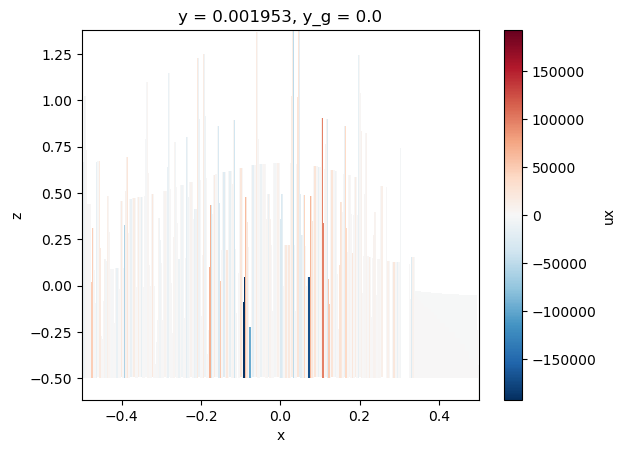

In [29]:
ds.ux.isel(y=128).plot(x='x', y='z')

In [19]:
c = (1/(2*np.pi))**0.5*0.25
c 

0.09973557010035818

In [20]:
ds.ux.max()

<xarray.DataArray 'ux' ()>
array(0.17667046)